# Данные

Данные в файле covid_flow.pkl
Данные включают поток пациентов с подтвержденным COVID-19 в ковидные стационары НИМЦ
Алмазова, Санкт-Петербург.

Датасет включает 1992 случая стационарного лечения COVID-19. Данные включают

•
Многомерные временные ряды, описывающие состояние пациента (интервал неделя)

•
План лечения (препараты и процедуры) для каждого пациента

•
Исходы лечения

Процесс стационарного лечения включает в себя два подпроцесса – контролирующий и контролируемый. 

Контролирующий –
назначение препаратов и процедур. 
Контролируемый – процесс изменения состояния пациентов.

Процесс лечения
включает в себя контролирующий процесс (назначение препарат и процедур) и контролируемый
процесс (процесс изменения состояния пациентов)

_stat_control – стационарные признаки, которые описывают контролирующий
процесс и не меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 препарата в план лечения)

_dinam_control – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это бинарные признаки включения 1 или
невключения 0 процедуры в план лечения)

_stat_fact – стационарные признаки, которые описывают контролируемый процесс
и не меняются (в covid_flow это признаки, описывающие пациентов, пол, возраст, и
все остальное что не меняется)

_dinam_fact – динамические признаки, которые описывают контролирующий
процесс и меняются (в covid_flow это признаки описывающие состояние
пациентов, например температура, % поражения легких и другое)

t_point – индикатор временного интервала. Вся длительность процесса разбита на
равные интервалы времени, t_point – метка интервала.

end_epizode – индикатор конца процесса, 0 – процесс лечения не окончен в
данном t_point, 1 – окончен

case (index) – уникальный идентификатор наблюдения (процесса), пример –
«GACAk+Q»

long_observation_tar – длинна процесса

current_process_duration – текущая длинна процесса (на момент t_point)

outcome_tar – исход лечения, 1- летальный, 0 – выздоровление.

# Прогноза значения индикатора пациента
Прогноз проходит в следующем периоде по иформации о
текущем состоянии и предыдущих состояниях. 
Таргеты – признаки с префиксами
_dinam_fact. 
Факторы – все признаки кроме тех что с префиксами _tar. 

На выходе нужен класс, который умеет принимать информацию о прошлых состояниях пациента, и
прогнозировать следующее. Надо попробовать RNN и Fedot

In [391]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
%matplotlib inline

import math
import keras
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import Model
from keras.layers import *
from keras.regularizers import L2

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.metrics import RootMeanSquaredError


In [392]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df.set_index(["case", "t_point"], inplace=True)
df = df.sort_values(["case", "t_point"])


# Check the data

Divide dataset to treatment and pynamic parameters

In [393]:
stat_fact_df = df.iloc[:,0:29]
stat_fact_df = stat_fact_df.sort_values(["case", "t_point"])

But initially check if treatment strategy has been changed? No. But found 22 records with no treatments at all.

In [394]:
non_typical_treatments = []
for i in stat_fact_df.index.levels[0]:
    means = stat_fact_df.loc[(i)].mean()
    if (set(means.unique()) != set([0,1])):
        non_typical_treatments.append([i, set(means.unique())])
non_typical_treatments

[['GACAJуЭ', {0.0}],
 ['GACAKАF', {0.0}],
 ['GACALрЫ', {0.0}],
 ['GACAT&H', {0.0}],
 ['GACA^МЮ', {0.0}],
 ['GACAb!2', {0.0}],
 ['GACAjц>', {0.0}],
 ['GACAjщ[', {0.0}],
 ['GACAjюc', {0.0}],
 ['GACAjяв', {0.0}],
 ["GACAk'5", {0.0}],
 ['GACAk){', {0.0}],
 ['GACAk+ц', {0.0}],
 ['GACAk.3', {0.0}],
 ['GACAm7g', {0.0}],
 ['GACAm?о', {0.0}],
 ['GACAmBц', {0.0}],
 ['GACAmCх', {0.0}],
 ['GACAmPф', {0.0}],
 ['GACAm^и', {0.0}],
 ['GACAmnW', {0.0}],
 ['GACAmЩП', {0.0}]]

*inof_df* static information about patient and treatment

In [395]:
info_df = pd.DataFrame()
info_df["age_stat_fact"] = df["age_stat_fact"]
info_df["outcome_tar"] = df["outcome_tar"]
info_df["long_observation_tar"] = df["long_observation_tar"]
info_df["admission_date"] = df["admission_date"]
info_df["process_stages"] = df["process_stages"]
periods = info_df.groupby("case").count()["age_stat_fact"]
info_df = info_df.groupby("case").first()
info_df["periods_stat_fact"] = periods
info_df

,age_stat_fact,outcome_tar,long_observation_tar,admission_date,process_stages,periods_stat_fact
case,,,,,,
GACAAcY,81,0,22,2021-01-29,2,4
GACAAnf,73,0,6,2020-06-06,1_2,2
GACABsT,59,0,14,2020-12-30,2,3
GACACKP,71,0,15,2021-01-26,2,3
GACADBj,37,0,20,2021-02-19,2,4
...,...,...,...,...,...,...
GACBAхz,25,0,14,2020-12-25,2,3
GACBAщн,37,0,15,2021-01-14,2,3
GACBB-В,70,0,1,2020-12-22,2,1


We see that measurements are 

In [396]:
df["current_process_duration"].value_counts()

3      1992
10     1939
17     1367
24      530
31      189
38       79
45       35
52       21
59        9
66        5
73        4
80        2
185       1
178       1
143       1
171       1
164       1
157       1
150       1
101       1
136       1
129       1
122       1
115       1
108       1
94        1
87        1
192       1
Name: current_process_duration, dtype: int64

dinam_fact_df with dinamic parameters changed during observation. These columns are targets for our task

In [397]:
dinam_fact_df = df.iloc[:,29:42]
dinam_fact_df = dinam_fact_df.sort_values(["case", "t_point"])

*dinam_control_df* procedures during observation. Unlike medicine, procedures has been changed during observation, so parameters pedends on time.

In [398]:
dinam_control_df = df.iloc[:,43:47]
dinam_control_df = dinam_control_df.sort_values(["case", "t_point"])

### Data preparation 

Make some transformations. Divide observations on train and test parts. We take some part as train period and next as test period. So we have X as (, WINDOW, PARAMS) and y (PARAMS)

In [399]:
dinam_fact_df

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                          36.7                   1.93   
        1                          36.3                   2.00   
        2                          36.6                   2.13   
        3                          36.5                   2.12   
GACAAnf 0                           NaN                   1.21   
...                                 ...                    ...   
GACBB;O 0                          36.9                   1.22   
        1                          36.5                   1.65   
GACXAAB 0                          36.5                   1.11   
        1                          36.9                   1.60   
        2                          36.6                   3.45   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0                 27.90            74.0            24.0   
        1                 25.70            71.0            19.0   
        2                 32.00             NaN            18.0   
        3                 27.00            71.0            18.0   
GACAAnf 0                 20.70            55.0            22.0   
...                         ...             ...             ...   
GACBB;O 0                 22.34            54.0            18.0   
        1                244.03             NaN            17.0   
GACXAAB 0                 21.80             NaN             NaN   
        1                 60.80            75.0            16.0   
        2                 17.20             NaN            15.0   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                             15.30   
        1                             12.10   
        2                               NaN   
        3                               NaN   
GACAAnf 0                              7.80   
...                                     ...   
GACBB;O 0                              1.43   
        1                              3.78   
GACXAAB 0                              4.50   
        1                              1.10   
        2                              9.30   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                           11.2   
        1                                           10.6   
        2                                           11.0   
        3                                           11.4   
GACAAnf 0                                            8.1   
...                                                  ...   
GACBB;O 0                                            7.0   
        1                                            7.2   
GACXAAB 0                                           10.6   
        1                                           10.8   
        2                                           10.0   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                             0.100                   48.3   
        1                             0.160                   30.7   
        2                             0.190                   23.1   
        3                             0.100                   24.1   
GACAAnf 0                             0.201                   24.1   
...                                     ...                    ...   
GACBB;O 0                             0.134                   33.0   
        1                             0.210                   41.2   
GACXAAB 0                             0.200                   18.8   
        1                             0.270                   12.9   
        2                             0.280          

In [400]:
print(f"Count of patients: {dinam_fact_df.index.levels[0].size}")

Count of patients: 1992


<AxesSubplot: >

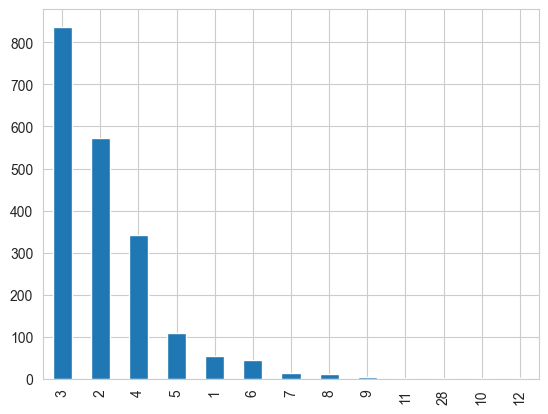

In [401]:
dinam_fact_df.groupby(["case"]).size().value_counts(sort=True).plot(kind="bar")

In [402]:
dinam_fact_df["Cтепень тяжести по КТ_dinam_fact"].value_counts().sort_index()

0      29
1     733
2    1250
3     696
4     195
5    3285
Name: Cтепень тяжести по КТ_dinam_fact, dtype: int64

Impute NaN values using MICE methods with IterativeImputer on Linear regression as estimator 

In [403]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
imp = IterativeImputer(estimator=LinearRegression(),
     missing_values=np.nan, max_iter=10, imputation_order='roman', random_state=0)
df_imputed = imp.fit_transform(dinam_fact_df)
scal_model = StandardScaler().fit(df_imputed)
df_scaled = scal_model.transform(df_imputed)
dinam_fact_df = pd.DataFrame(data=df_scaled, columns = dinam_fact_df.columns, index=dinam_fact_df.index)
dinam_fact_df

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                      0.294819               0.015927   
        1                     -1.153704               0.030925   
        2                     -0.067312               0.058778   
        3                     -0.429443               0.056635   
GACAAnf 0                      0.300794              -0.138336   
...                                 ...                    ...   
GACBB;O 0                      1.019080              -0.136194   
        1                     -0.429443              -0.044064   
GACXAAB 0                     -0.429443              -0.159762   
        1                      1.019080              -0.054777   
        2                     -0.067312               0.341594   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0             -0.245854        0.091632        1.027241   
        1             -0.276895       -0.113206       -0.087114   
        2             -0.188004       -0.065290       -0.309985   
        3             -0.258553       -0.113206       -0.309985   
GACAAnf 0             -0.347444       -1.205676        0.581499   
...                         ...             ...             ...   
GACBB;O 0             -0.324304       -1.273955       -0.309985   
        1              2.803689       -0.222816       -0.532856   
GACXAAB 0             -0.331924       -0.217121        0.094297   
        1              0.218357        0.159911       -0.755727   
        2             -0.396828        0.024789       -0.978598   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                          0.943518   
        1                          0.399479   
        2                          0.124866   
        3                          0.263962   
GACAAnf 0                         -0.331573   
...                                     ...   
GACBB;O 0                         -1.414550   
        1                         -1.015022   
GACXAAB 0                         -0.892613   
        1                         -1.470654   
        2                         -0.076555   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                       1.241817   
        1                                       0.861815   
        2                                       1.115149   
        3                                       1.368484   
GACAAnf 0                                      -0.721528   
...                                                  ...   
GACBB;O 0                                      -1.418198   
        1                                      -1.291531   
GACXAAB 0                                       0.861815   
        1                                       0.988482   
        2                                       0.481812   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                         -1.329396               2.025719   
        1                         -0.738803               0.576399   
        2                         -0.443506              -0.049444   
        3                         -1.329396               0.032904   
GACAAnf 0                         -0.335231               0.032904   
...                                     ...                    ...   
GACBB;O 0                         -0.994727               0.765799   
        1                         -0.246642               1.441050   
GACXAAB 0                         -0.345074              -0.403539   
        1                          0.343952              -0.889390   
        2                          0.442384          

Norm data by Standart Scaler and divide and train test parts

In [404]:
scal_model = StandardScaler().fit(df_imputed)
df_scaled = scal_model.transform(df_imputed)
df_scaled

array([[ 0.29481863,  0.01592704, -0.24585399, ..., -1.04515494,
        -0.4520992 , -0.31969103],
       [-1.15370422,  0.03092487, -0.27689547, ..., -1.04515494,
        -0.05562054, -0.65881207],
       [-0.06731208,  0.05877799, -0.18800395, ...,  0.8663974 ,
        -0.19722006, -0.46099146],
       ...,
       [-0.42944279, -0.15976184, -0.33192355, ..., -1.68233905,
        -0.59936271, -0.96967302],
       [ 1.01908006, -0.05477702,  0.21835725, ...,  0.8663974 ,
         0.05765908, -0.48925155],
       [-0.06731208,  0.34159424, -0.39682846, ...,  0.8663974 ,
        -0.25952385, -0.9979331 ]])

In [405]:
df_scaled = pd.DataFrame(df_scaled, index=dinam_fact_df.index, columns=dinam_fact_df.columns)
df_scaled

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                      0.294819               0.015927   
        1                     -1.153704               0.030925   
        2                     -0.067312               0.058778   
        3                     -0.429443               0.056635   
GACAAnf 0                      0.300794              -0.138336   
...                                 ...                    ...   
GACBB;O 0                      1.019080              -0.136194   
        1                     -0.429443              -0.044064   
GACXAAB 0                     -0.429443              -0.159762   
        1                      1.019080              -0.054777   
        2                     -0.067312               0.341594   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0             -0.245854        0.091632        1.027241   
        1             -0.276895       -0.113206       -0.087114   
        2             -0.188004       -0.065290       -0.309985   
        3             -0.258553       -0.113206       -0.309985   
GACAAnf 0             -0.347444       -1.205676        0.581499   
...                         ...             ...             ...   
GACBB;O 0             -0.324304       -1.273955       -0.309985   
        1              2.803689       -0.222816       -0.532856   
GACXAAB 0             -0.331924       -0.217121        0.094297   
        1              0.218357        0.159911       -0.755727   
        2             -0.396828        0.024789       -0.978598   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                          0.943518   
        1                          0.399479   
        2                          0.124866   
        3                          0.263962   
GACAAnf 0                         -0.331573   
...                                     ...   
GACBB;O 0                         -1.414550   
        1                         -1.015022   
GACXAAB 0                         -0.892613   
        1                         -1.470654   
        2                         -0.076555   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                       1.241817   
        1                                       0.861815   
        2                                       1.115149   
        3                                       1.368484   
GACAAnf 0                                      -0.721528   
...                                                  ...   
GACBB;O 0                                      -1.418198   
        1                                      -1.291531   
GACXAAB 0                                       0.861815   
        1                                       0.988482   
        2                                       0.481812   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                         -1.329396               2.025719   
        1                         -0.738803               0.576399   
        2                         -0.443506              -0.049444   
        3                         -1.329396               0.032904   
GACAAnf 0                         -0.335231               0.032904   
...                                     ...                    ...   
GACBB;O 0                         -0.994727               0.765799   
        1                         -0.246642               1.441050   
GACXAAB 0                         -0.345074              -0.403539   
        1                          0.343952              -0.889390   
        2                          0.442384          

In [406]:
#module divides on X [[1, 2, 3, 4]] and y [5]
WINDOW = 3
PARAMS_LENGTH = 13

def df_to_X_y(df, window = 3):
    X, y = [], []
    for i in df.index.levels[0]:
        len_time_serie = dinam_fact_df.groupby(["case"]).size()[i]
        if (len_time_serie < window+1):
            continue
        X.append(df.loc[(i, 0): (i, window-1)].to_numpy())
        y.append(df.loc[(i, window)].to_numpy())
    return np.array(X), np.array(y)

X, y = df_to_X_y(df_scaled, WINDOW)
X

array([[[ 0.29481863,  0.01592704, -0.24585399, ..., -1.04515494,
         -0.4520992 , -0.31969103],
        [-1.15370422,  0.03092487, -0.27689547, ..., -1.04515494,
         -0.05562054, -0.65881207],
        [-0.06731208,  0.05877799, -0.18800395, ...,  0.8663974 ,
         -0.19722006, -0.46099146]],

       [[-0.06731208, -0.16404694,  2.54082442, ..., -0.40797082,
          1.98341257, -1.19575371],
        [-0.79157351,  0.12733951, -0.30088207, ...,  0.8663974 ,
         -0.21987599, -0.9979331 ],
        [-0.79157351, -0.09977052, -0.31358086, ...,  0.8663974 ,
          0.09730694, -0.82837258]],

       [[-0.79157351, -0.16618948, -0.48571998, ..., -0.40797082,
          0.02367519, -0.54577172],
        [-0.79157351, -0.12548108, -0.2571418 , ...,  0.8663974 ,
         -0.27085182, -0.43273137],
        [ 0.65694934, -0.10405561, -0.4067053 , ...,  0.8663974 ,
         -0.55405086, -0.15013051]],

       ...,

       [[ 2.82973362, -0.13619382, -0.13861978, ..., -1.6823390

Divide on test and train splits and delete last element to divide samples on batches

In [407]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/11)
X_train, y_train = X_train[:-1], y_train[:-1]
X_test, y_test = X_test[:-1], y_test[:-1]
print(X_train.shape)
print(y_test.shape)

(480, 3, 13)
(48, 13)


### Training

In [453]:
#function with results 
def show_results(X_test, y_test, model, history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.plot(history.history["val_root_mean_squared_error"])
    plt.legend(["train loss", "validation loss", "validation root_mean_squared_error"])
    y_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
    r2_stat = r2_score(y_pred, y_test, multioutput="raw_values")
    predicted_values = scal_model.inverse_transform(y_pred)
    real_values = scal_model.inverse_transform(y_test)
    last_values = []
    last_values.extend(scal_model.inverse_transform(X_test[0]))
    stat=[]
    stat.extend(last_values)
    stat.append(real_values[0])
    stat.append(predicted_values[0])
    stat.append(r2_stat)
    df = pd.DataFrame(stat, index=[*["prev"]*len(last_values), "real", "predicted", "R2"], columns=dinam_fact_df.columns)
    print("Parameters on test datasets: \n")
    display(df)
    print(list(zip(model.metrics_names, model.evaluate(X_test, y_test, batch_size=BATCH_SIZE))))
    

### One layer RNN size 13

1. Simple RNN with state units 13 and batch size 1

In [455]:
BATCH_SIZE=1

model = Sequential(name="RNN13")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(SimpleRNN(PARAMS_LENGTH, activation="relu", return_sequences=False))
model_simple_rnn_13 = model
model_simple_rnn_13.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_simple_rnn_13.summary()

Model: "RNN13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (1, 13)                   351       
                                                                 
Total params: 351
Trainable params: 351
Non-trainable params: 0
_________________________________________________________________


Lets show learning history for the model. We see intersection on 15 epochs - model becomes overfit.

In [456]:
history = model_simple_rnn_13.fit(X_train, y_train,
 epochs=10, validation_split=1/8, batch_size=BATCH_SIZE,
 shuffle=False, verbose=0)
model_simple_rnn_13.save("RNN13")

INFO:tensorflow:Assets written to: RNN13\assets


INFO:tensorflow:Assets written to: RNN13\assets


Lets show on table what we have predicted:

InvalidArgumentError: Graph execution error:

Detected at node 'RNN13/simple_rnn_3/TensorArrayUnstack/TensorListFromTensor' defined at (most recent call last):
    File "C:\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\sirau\AppData\Local\Temp\ipykernel_17580\2075577286.py", line 1, in <module>
      show_results(X_test, y_test, model_simple_rnn_13, history)
    File "C:\Users\sirau\AppData\Local\Temp\ipykernel_17580\2348553085.py", line 7, in show_results
      y_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\layers\rnn\base_rnn.py", line 553, in __call__
      return super().__call__(inputs, **kwargs)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\layers\rnn\simple_rnn.py", line 410, in call
      return super().call(
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\layers\rnn\base_rnn.py", line 719, in call
      last_output, outputs, states = backend.rnn(
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\backend.py", line 4939, in rnn
      input_ta = tuple(
    File "C:\Users\sirau\OneDrive\Desktop\datascience\covid\venv\lib\site-packages\keras\backend.py", line 4940, in <genexpr>
      ta.unstack(input_)
Node: 'RNN13/simple_rnn_3/TensorArrayUnstack/TensorListFromTensor'
Specified a list with shape [1,13] from a tensor with shape [12,13]
	 [[{{node RNN13/simple_rnn_3/TensorArrayUnstack/TensorListFromTensor}}]] [Op:__inference_predict_function_942488]

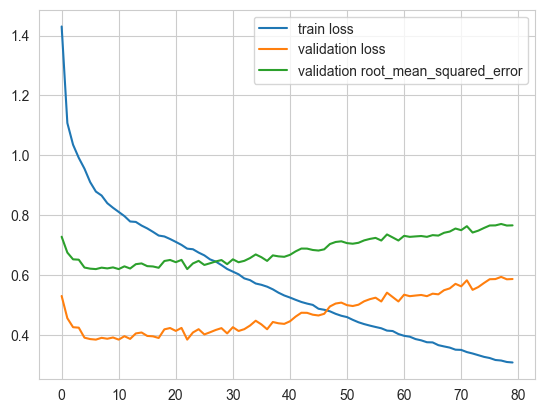

In [454]:
show_results(X_test, y_test, model_simple_rnn_13, history)

### LSTM with 13 units and batch 1

In [412]:
BATCH_SIZE=1

model = Sequential(name="LSTM13")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model_lstm_13 = model
model_lstm_13.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_13.summary()

Model: "LSTM13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (1, 13)                   1404      
                                                                 
Total params: 1,404
Trainable params: 1,404
Non-trainable params: 0
_________________________________________________________________


In [413]:
history = model_lstm_13.fit(X_train, y_train,
 epochs=30, validation_split=1/8, batch_size=BATCH_SIZE,
 shuffle=False, verbose=0)
model_lstm_13.save("LSTM13")


INFO:tensorflow:Assets written to: LSTM13\assets


INFO:tensorflow:Assets written to: LSTM13\assets


Parameters on test datasets: 



,0,1,2,3,4,5,6,7,8,9,10,11,12
prev,38.800000,1.410000,83.200000,1.000000,21.000000,4.400000,10.400000,0.120000,33.500000,0.000000,3.000000,882.000000,11.900000
prev,36.600000,2.230000,63.400000,91.000000,20.000000,11.700000,10.000000,0.480000,22.300000,0.000000,3.000000,475.000000,10.900000
prev,36.300000,2.030000,17.300000,77.000000,18.000000,7.800000,10.900000,0.330000,11.600000,0.000000,5.000000,230.000000,13.200000
real,36.600000,1.880000,23.100000,72.988563,16.000000,10.201314,10.900000,0.240000,10.800000,0.000000,5.000000,505.000000,12.600000
predicted,36.513233,2.094215,32.073212,74.853477,17.090544,8.059443,10.225101,0.192784,21.375378,-0.015755,4.543494,265.378296,12.736553
R2,-4.005085,-36.815076,-0.018630,-21.434491,-3.322914,-1.261143,0.038297,-1.121252,-2.034237,-4.575623,-13.976316,-0.471175,0.321560


48/48 [==============================] - 0s 2ms/step - loss: 0.6177 - root_mean_squared_error: 0.7859
[('loss', 0.617704451084137), ('root_mean_squared_error', 0.7859416604042053)]


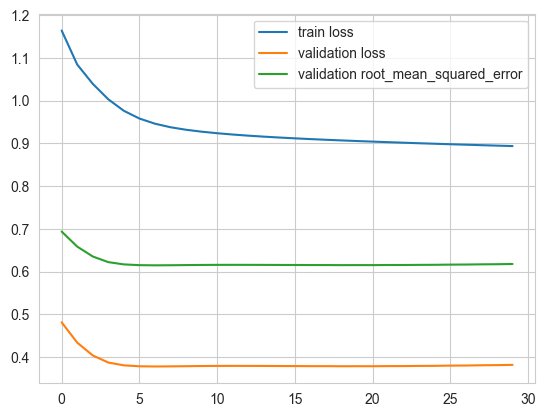

In [414]:
show_results(X_test, y_test, model_lstm_13, history)

### LSTM13 with batch 12

In [415]:
BATCH_SIZE=12

model = Sequential(name="LSTM13Batch12")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model_lstm_13_b12 = model
model_lstm_13_b12.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_13_b12.summary()

Model: "LSTM13Batch12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (12, 13)                  1404      
                                                                 
Total params: 1,404
Trainable params: 1,404
Non-trainable params: 0
_________________________________________________________________


In [416]:
history = model_lstm_13_b12.fit(X_train, y_train,
 epochs=30, validation_split=1/8, batch_size=BATCH_SIZE,
 shuffle=False, verbose=0)
model_lstm_13.save("LSTM13Batch12")

INFO:tensorflow:Assets written to: LSTM13Batch12\assets


INFO:tensorflow:Assets written to: LSTM13Batch12\assets


Parameters on test datasets: 



,0,1,2,3,4,5,6,7,8,9,10,11,12
prev,38.800000,1.410000,83.200000,1.000000,21.000000,4.400000,10.400000,0.120000,33.500000,0.000000,3.000000,882.000000,11.900000
prev,36.600000,2.230000,63.400000,91.000000,20.000000,11.700000,10.000000,0.480000,22.300000,0.000000,3.000000,475.000000,10.900000
prev,36.300000,2.030000,17.300000,77.000000,18.000000,7.800000,10.900000,0.330000,11.600000,0.000000,5.000000,230.000000,13.200000
real,36.600000,1.880000,23.100000,72.988563,16.000000,10.201314,10.900000,0.240000,10.800000,0.000000,5.000000,505.000000,12.600000
predicted,36.503922,2.002182,35.451241,70.605988,17.664936,9.630439,9.819885,0.214367,20.706102,0.061718,4.367949,317.867920,13.338339
R2,-5.958099,-42.962054,-0.004889,-83.350034,-5.630307,-2.024748,-0.271760,-2.063844,-5.868311,-5.368581,-30.794853,-0.802459,-0.531307


4/4 [==============================] - 0s 3ms/step - loss: 0.6202 - root_mean_squared_error: 0.7876
[('loss', 0.6202390789985657), ('root_mean_squared_error', 0.7875525951385498)]


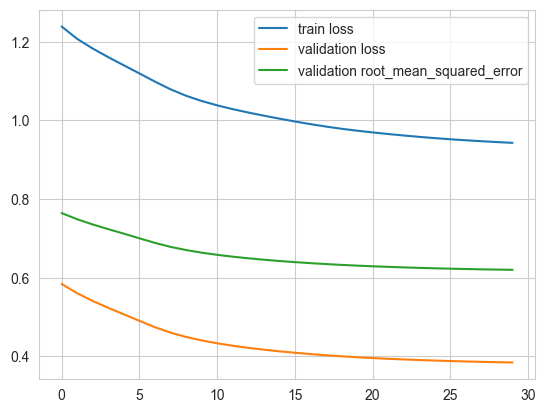

In [417]:
show_results(X_test, y_test, model_lstm_13_b12, history)

### LSTM64 Encoder + LSTM 13 Decoder 

In [418]:
BATCH_SIZE=12

model = Sequential(name="LSTM64xLSTM13")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model_lstm_64 = model
model_lstm_64.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_64.summary()

Model: "LSTM64xLSTM13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (12, 3, 64)               19968     
                                                                 
 lstm_56 (LSTM)              (12, 13)                  4056      
                                                                 
Total params: 24,024
Trainable params: 24,024
Non-trainable params: 0
_________________________________________________________________


In [419]:
history = model_lstm_64.fit(X_train, y_train,
 epochs=30, validation_split=1/8, batch_size=BATCH_SIZE,
 shuffle=False, verbose=0)
model_lstm_64.save("LSTM64xLSTM13")

INFO:tensorflow:Assets written to: LSTM64xLSTM13\assets


INFO:tensorflow:Assets written to: LSTM64xLSTM13\assets


Parameters on test datasets: 



,0,1,2,3,4,5,6,7,8,9,10,11,12
prev,38.800000,1.410000,83.200000,1.000000,21.000000,4.400000,10.400000,0.120000,33.500000,0.000000,3.000000,882.000000,11.900000
prev,36.600000,2.230000,63.400000,91.000000,20.000000,11.700000,10.000000,0.480000,22.300000,0.000000,3.000000,475.000000,10.900000
prev,36.300000,2.030000,17.300000,77.000000,18.000000,7.800000,10.900000,0.330000,11.600000,0.000000,5.000000,230.000000,13.200000
real,36.600000,1.880000,23.100000,72.988563,16.000000,10.201314,10.900000,0.240000,10.800000,0.000000,5.000000,505.000000,12.600000
predicted,36.588600,1.852847,31.391800,65.275696,17.650566,7.087744,10.382201,0.229417,15.674523,0.043359,4.572178,240.152390,12.427855
R2,-3.930677,-43.915326,0.118614,-12.320983,-4.398711,-0.905106,0.027311,-0.710769,-2.684628,-5.150450,-8.982000,-0.336988,0.278655


4/4 [==============================] - 0s 5ms/step - loss: 0.6093 - root_mean_squared_error: 0.7806
[('loss', 0.609312891960144), ('root_mean_squared_error', 0.7805849313735962)]


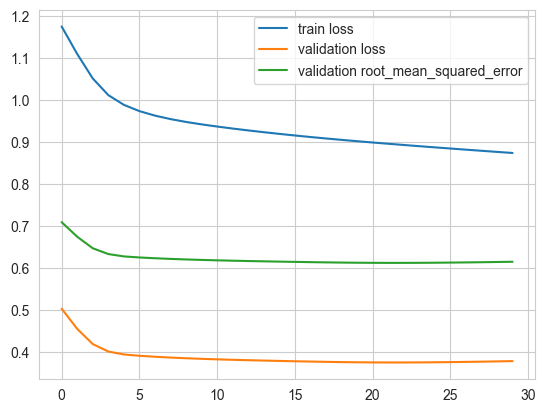

In [420]:
show_results(X_test, y_test, model_lstm_64, history)

## LSTM64+Dense13

In [421]:
BATCH_SIZE=12

model = Sequential(name="LSTM64xDense13")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model_lstm_dense = model
model_lstm_dense.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])
model_lstm_dense.summary()

Model: "LSTM64xDense13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (12, 64)                  19968     
                                                                 
 dense_96 (Dense)            (12, 13)                  845       
                                                                 
Total params: 20,813
Trainable params: 20,813
Non-trainable params: 0
_________________________________________________________________


In [422]:
history = model_lstm_dense.fit(X_train, y_train,
 epochs=30, validation_split=1/8, batch_size=BATCH_SIZE,
 shuffle=False, verbose=0)
model_lstm_64.save("LSTM64xDense13")

INFO:tensorflow:Assets written to: LSTM64xDense13\assets


INFO:tensorflow:Assets written to: LSTM64xDense13\assets


Parameters on test datasets: 



,0,1,2,3,4,5,6,7,8,9,10,11,12
prev,38.800000,1.410000,83.200000,1.000000,21.000000,4.400000,10.400000,0.120000,33.500000,0.000000,3.000000,882.000000,11.900000
prev,36.600000,2.230000,63.400000,91.000000,20.000000,11.700000,10.000000,0.480000,22.300000,0.000000,3.000000,475.000000,10.900000
prev,36.300000,2.030000,17.300000,77.000000,18.000000,7.800000,10.900000,0.330000,11.600000,0.000000,5.000000,230.000000,13.200000
real,36.600000,1.880000,23.100000,72.988563,16.000000,10.201314,10.900000,0.240000,10.800000,0.000000,5.000000,505.000000,12.600000
predicted,36.559338,0.477924,28.123478,74.748268,17.332243,7.241710,10.924333,0.235771,18.539116,-0.000609,4.494036,273.096558,12.314532
R2,-2.862238,0.949077,0.596129,-10.265066,-1.213426,0.218987,0.395492,-0.813972,0.248782,0.983675,-10.035704,0.361232,0.225983


4/4 [==============================] - 0s 6ms/step - loss: 0.4947 - root_mean_squared_error: 0.7033
[('loss', 0.49466753005981445), ('root_mean_squared_error', 0.7033260464668274)]


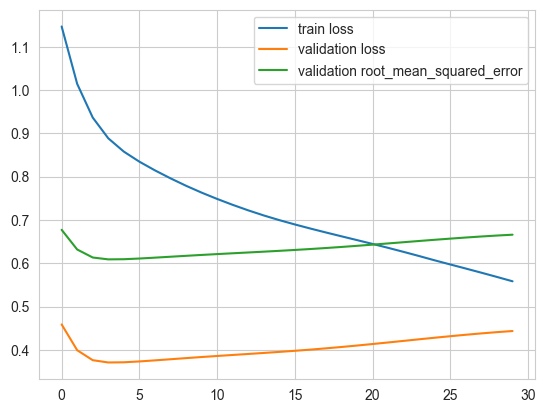

In [423]:
show_results(X_test, y_test, model_lstm_dense, history)

### Lets add static parameters as additional inputs to fully connected layer

In [424]:
def split_features_targets(df, dinam_fact_df, window=3):
    X, y = [], []
    for i in df.index.levels[0]:
        len_ts = dinam_fact_df.groupby(["case"]).size()[i]
        if len_ts < window+1:
            continue
        sample_data = np.array([])
        for j in range(window):
            sample_data = np.append(sample_data, dinam_fact_df.loc[(i, j)].to_numpy()) # facts
            sample_data = np.append(sample_data, df.loc[(i, j)].iloc[43:47].to_numpy()) #controls
        sample_data = np.append(sample_data, df.loc[(i, 0)].iloc[:29].to_numpy()) #medicines
        sample_data = np.append(sample_data, df.loc[(i, 0)].iloc[42]) #age
        X.append(sample_data)
        y.append(dinam_fact_df.loc[(i, window)].to_numpy())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/11)
    X, T, y = [], [], []
    X_t, T_t, y_t = [], [], []
    for i in range(len(X_train)):
        X.append(X_train[i][:window*17].reshape(3, 17))
        T.append(X_train[i][window*17:])
        y = y_train.copy()
    for i in range(len(X_test)):
        X_t.append(X_test[i][:window*17].reshape(3, 17))
        T_t.append(X_test[i][window*17:])
        y_t = y_test.copy()

    return (np.array(X).astype(np.float32), np.array(T).astype(np.float32), np.array(y)), (np.array(X_t).astype(np.float32), np.array(T_t).astype(np.float32), np.array(y_t))

In [425]:
(X, T, y), (X_t, T_t, y_t) = split_features_targets(df, dinam_fact_df)

Now we have such dinam_facts and dinam_controls frame:

In [426]:
X[7]

array([[ 5.7267795 , -0.11048325,  0.32418048, -0.04492673,  0.5814994 ,
        -0.82460827,  0.7351473 ,  0.04865517, -0.5517645 , -0.25027362,
        -1.6823391 , -0.31616366, -0.96967304,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.4294428 , -0.12762363,  0.7855698 , -0.9325581 ,  0.13575734,
        -0.03283146,  0.3551451 ,  1.6235713 , -0.7823381 , -0.25027362,
         0.22921328,  1.5925978 , -1.1957537 ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.06731208, -0.20261279, -0.40247238, -0.59116143, -0.30998468,
         0.19546469,  0.5451462 ,  2.2141647 , -1.3093634 , -0.25027362,
         0.8663974 ,  0.13129082, -1.1957537 ,  0.        ,  0.        ,
         0.        ,  0.        ]], dtype=float32)

And frame with information about medicines and age:

In [427]:
T[7]

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., 61.], dtype=float32)

In [428]:
T = T[:-1]
X = X[:-1]
y = y[:-1]
T_t = T_t[:-1]
X_t = X_t[:-1]
y_t = y_t[:-1]
print("T: ", T.shape)
print("X: ", X.shape)
print("y: ", y.shape)
print("T: ", T_t.shape)
print("X: ", X_t.shape)
print("y: ", y_t.shape)

T:  (480, 30)
X:  (480, 3, 17)
y:  (480, 13)
T:  (48, 30)
X:  (48, 3, 17)
y:  (48, 13)


In [429]:
BATCH_SIZE = 12
input_static = Input((30), batch_size=BATCH_SIZE)
input_dinamic = Input((3, 17), batch_size=BATCH_SIZE)
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(17, return_state=False)(input_dinamic)
result_layer = Dense(13, activation='linear')(lstm_layer)
model_multi = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi.summary()
model_multi.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_94 (InputLayer)          [(12, 3, 17)]        0           []                               
                                                                                                  
 lstm_58 (LSTM)                 (12, 17)             2380        ['input_94[0][0]']               
                                                                                                  
 input_93 (InputLayer)          [(12, 30)]           0           []                               
                                                                                                  
 dense_98 (Dense)               (12, 13)             234         ['lstm_58[0][0]']                
                                                                                           

In [430]:
history = model_multi.fit(x=[T, X], y=y, batch_size=BATCH_SIZE, validation_split=1/8, epochs=80)

Epoch 1/80
35/35 [==============================] - 2s 22ms/step - loss: 1.2277 - root_mean_squared_error: 1.1080 - val_loss: 0.5388 - val_root_mean_squared_error: 0.7341
Epoch 2/80
35/35 [==============================] - 0s 7ms/step - loss: 1.1701 - root_mean_squared_error: 1.0817 - val_loss: 0.4955 - val_root_mean_squared_error: 0.7039
Epoch 3/80
35/35 [==============================] - 0s 6ms/step - loss: 1.1220 - root_mean_squared_error: 1.0592 - val_loss: 0.4589 - val_root_mean_squared_error: 0.6774
Epoch 4/80
35/35 [==============================] - 0s 7ms/step - loss: 1.0801 - root_mean_squared_error: 1.0393 - val_loss: 0.4283 - val_root_mean_squared_error: 0.6545
Epoch 5/80
35/35 [==============================] - 0s 6ms/step - loss: 1.0423 - root_mean_squared_error: 1.0209 - val_loss: 0.4041 - val_root_mean_squared_error: 0.6357
Epoch 6/80
35/35 [==============================] - 0s 6ms/step - loss: 1.0114 - root_mean_squared_error: 1.0057 - val_loss: 0.3863 - val_root_mean_s

In [431]:
def show_results(X_test, T_test, y_test, model, history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.plot(history.history["val_root_mean_squared_error"])
    plt.legend(["train loss", "validation loss", "validation root_mean_squared_error"])
    y_pred = model.predict([T_test, X_test], batch_size=BATCH_SIZE, verbose=0)
    r2_stat = r2_score(y_pred, y_test, multioutput="raw_values")
    r2_stat = np.array(r2_stat).reshape(1, 13)
    df = pd.DataFrame(r2_stat, index=["R2"], columns=dinam_fact_df.columns)
    print("Parameters on test datasets: \n")
    display(df)
    print(list(zip(model.metrics_names, model.evaluate([T_test, X_test], y_test, batch_size=BATCH_SIZE))))

Parameters on test datasets: 



,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-9.555172,-0.019092,-1.664573,-21.718214,-10.278727,-0.022969,0.213461,-3.134838,-0.325362,-12.927429,-10.006492,-4.173872,0.224649


4/4 [==============================] - 0s 6ms/step - loss: 0.5023 - root_mean_squared_error: 0.7088
[('loss', 0.5023365020751953), ('root_mean_squared_error', 0.7087569832801819)]


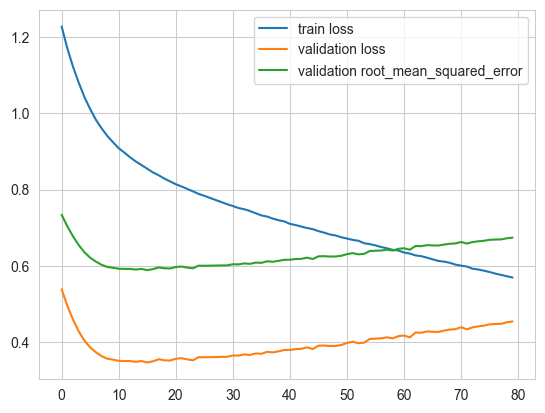

In [432]:
show_results(X_t, T_t, y_t, model_multi, history)

Lets try tanh activation in last layer

In [433]:
BATCH_SIZE = 12
input_static = Input((30), batch_size=BATCH_SIZE)
input_dinamic = Input((3, 17), batch_size=BATCH_SIZE)
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(17, return_state=False)(input_dinamic)
result_layer = Dense(13, activation='tanh')(lstm_layer)
model_multi_tan = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi_tan.summary()
model_multi_tan.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_96 (InputLayer)          [(12, 3, 17)]        0           []                               
                                                                                                  
 lstm_59 (LSTM)                 (12, 17)             2380        ['input_96[0][0]']               
                                                                                                  
 input_95 (InputLayer)          [(12, 30)]           0           []                               
                                                                                                  
 dense_100 (Dense)              (12, 13)             234         ['lstm_59[0][0]']                
                                                                                           

In [434]:
history = model_multi_tan.fit(x=[T, X], y=y, batch_size=BATCH_SIZE, validation_split=1/8, epochs=80)

Epoch 1/80
35/35 [==============================] - 2s 25ms/step - loss: 1.2707 - root_mean_squared_error: 1.1273 - val_loss: 0.5990 - val_root_mean_squared_error: 0.7740
Epoch 2/80
35/35 [==============================] - 0s 5ms/step - loss: 1.2123 - root_mean_squared_error: 1.1011 - val_loss: 0.5562 - val_root_mean_squared_error: 0.7458
Epoch 3/80
35/35 [==============================] - 0s 8ms/step - loss: 1.1656 - root_mean_squared_error: 1.0796 - val_loss: 0.5179 - val_root_mean_squared_error: 0.7196
Epoch 4/80
35/35 [==============================] - 0s 5ms/step - loss: 1.1259 - root_mean_squared_error: 1.0611 - val_loss: 0.4876 - val_root_mean_squared_error: 0.6983
Epoch 5/80
35/35 [==============================] - 0s 4ms/step - loss: 1.0944 - root_mean_squared_error: 1.0461 - val_loss: 0.4635 - val_root_mean_squared_error: 0.6808
Epoch 6/80
35/35 [==============================] - 0s 6ms/step - loss: 1.0685 - root_mean_squared_error: 1.0337 - val_loss: 0.4450 - val_root_mean_s

Parameters on test datasets: 



,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-8.276214,-0.113021,-7.84417,-14.240714,-8.003091,-5.57908,-0.102427,-2.998301,-1.248154,-25.708969,-4.421246,-4.722639,-0.005833


4/4 [==============================] - 0s 4ms/step - loss: 0.4615 - root_mean_squared_error: 0.6794
[('loss', 0.4615321159362793), ('root_mean_squared_error', 0.6793615818023682)]


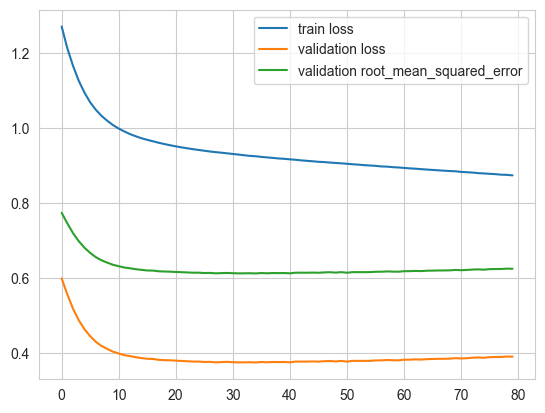

In [435]:
show_results(X_t, T_t, y_t, model_multi_tan, history)

We see that this does not show any grow. Lets try the network from (Sicen Liu et al.) But without GNN

In [439]:
BATCH_SIZE = 12
input_static = Input((30), batch_size=BATCH_SIZE)
input_dinamic = Input((3, 17), batch_size=BATCH_SIZE)
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(17, return_state=True)(input_dinamic)
lstm_layer_last = LSTM(17, return_state=False)(input_dinamic)
flat_lst_layer = concatenate(lstm_layer)
result_layer = Dense(32, activation='tanh')(concatenate([flat_lst_layer, lstm_layer_last, dense_layer]))
result_layer = Dense(13, activation='linear')(result_layer)
model_multi_tan = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi_tan.summary()
model_multi_tan.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_100 (InputLayer)         [(12, 3, 17)]        0           []                               
                                                                                                  
 lstm_62 (LSTM)                 [(12, 17),           2380        ['input_100[0][0]']              
                                 (12, 17),                                                        
                                 (12, 17)]                                                        
                                                                                                  
 input_99 (InputLayer)          [(12, 30)]           0           []                               
                                                                                           

Epoch 1/80
35/35 [==============================] - 3s 9ms/step - loss: 1.4305 - root_mean_squared_error: 1.1960 - val_loss: 0.5298 - val_root_mean_squared_error: 0.7279
Epoch 2/80
35/35 [==============================] - 0s 6ms/step - loss: 1.1079 - root_mean_squared_error: 1.0526 - val_loss: 0.4555 - val_root_mean_squared_error: 0.6749
Epoch 3/80
35/35 [==============================] - 0s 6ms/step - loss: 1.0354 - root_mean_squared_error: 1.0175 - val_loss: 0.4255 - val_root_mean_squared_error: 0.6523
Epoch 4/80
35/35 [==============================] - 0s 7ms/step - loss: 0.9914 - root_mean_squared_error: 0.9957 - val_loss: 0.4240 - val_root_mean_squared_error: 0.6511
Epoch 5/80
35/35 [==============================] - 0s 6ms/step - loss: 0.9552 - root_mean_squared_error: 0.9774 - val_loss: 0.3904 - val_root_mean_squared_error: 0.6249
Epoch 6/80
35/35 [==============================] - 0s 6ms/step - loss: 0.9103 - root_mean_squared_error: 0.9541 - val_loss: 0.3858 - val_root_mean_sq

,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-5.272854,0.03445,-1.051185,-3.215359,-4.122853,-0.432089,0.21769,-1.55317,-0.35742,-7.180234,-4.319111,-2.205134,0.028735


4/4 [==============================] - 0s 5ms/step - loss: 0.5906 - root_mean_squared_error: 0.7685
[('loss', 0.5906486511230469), ('root_mean_squared_error', 0.7685366868972778)]


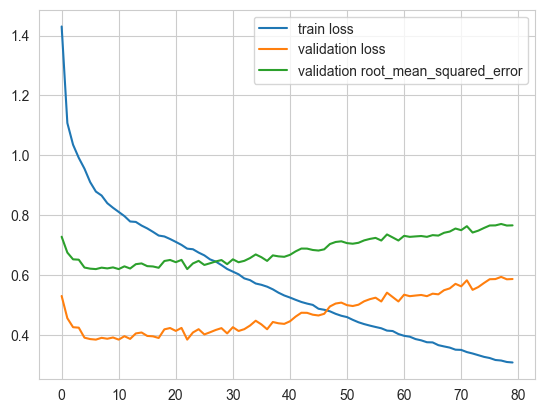

In [451]:
history = model_multi_tan.fit(x=[T, X], y=y, batch_size=BATCH_SIZE, validation_split=1/8, epochs=80)
show_results(X_t, T_t, y_t, model_multi_tan, history)

In [444]:
BATCH_SIZE = 12
input_static = Input((30), batch_size=BATCH_SIZE)
input_dinamic = Input((3, 17), batch_size=BATCH_SIZE)
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(32, return_state=True)(input_dinamic)
flat_lst_layer = concatenate(lstm_layer)
result_layer = Dense(32, activation='tanh')(concatenate([flat_lst_layer, dense_layer]))
result_layer = Dense(13, activation='linear')(result_layer)
model_multi_s2 = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi_s2.summary()
model_multi_s2.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_104 (InputLayer)         [(12, 3, 17)]        0           []                               
                                                                                                  
 lstm_65 (LSTM)                 [(12, 32),           6400        ['input_104[0][0]']              
                                 (12, 32),                                                        
                                 (12, 32)]                                                        
                                                                                                  
 input_103 (InputLayer)         [(12, 30)]           0           []                               
                                                                                           

Epoch 1/80
35/35 [==============================] - 0s 8ms/step - loss: 0.3133 - root_mean_squared_error: 0.5597 - val_loss: 0.7259 - val_root_mean_squared_error: 0.8520
Epoch 2/80
35/35 [==============================] - 0s 9ms/step - loss: 0.3062 - root_mean_squared_error: 0.5534 - val_loss: 0.8163 - val_root_mean_squared_error: 0.9035
Epoch 3/80
35/35 [==============================] - 0s 8ms/step - loss: 0.2995 - root_mean_squared_error: 0.5473 - val_loss: 0.8143 - val_root_mean_squared_error: 0.9024
Epoch 4/80
35/35 [==============================] - 0s 6ms/step - loss: 0.2950 - root_mean_squared_error: 0.5432 - val_loss: 0.8533 - val_root_mean_squared_error: 0.9237
Epoch 5/80
35/35 [==============================] - 0s 6ms/step - loss: 0.2942 - root_mean_squared_error: 0.5424 - val_loss: 0.8565 - val_root_mean_squared_error: 0.9255
Epoch 6/80
35/35 [==============================] - 0s 8ms/step - loss: 0.2909 - root_mean_squared_error: 0.5393 - val_loss: 0.8326 - val_root_mean_sq

,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-1.789781,0.033177,-0.300704,-1.582471,-3.225497,0.25493,0.460556,-0.281412,-0.038541,-5.529859,-1.057617,-0.851852,0.406283


4/4 [==============================] - 0s 5ms/step - loss: 0.8102 - root_mean_squared_error: 0.9001
[('loss', 0.8101623058319092), ('root_mean_squared_error', 0.9000901579856873)]


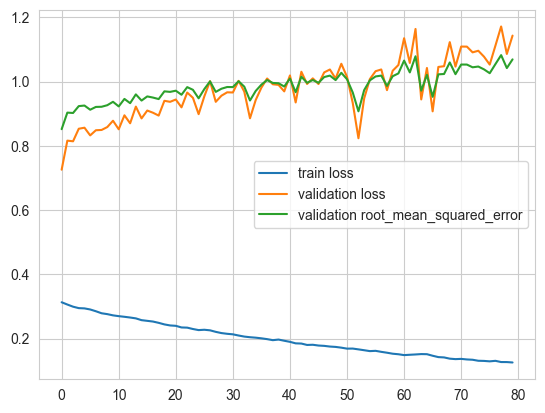

In [447]:
history = model_multi_s2.fit(x=[T, X], y=y, batch_size=BATCH_SIZE, validation_split=1/8, epochs=80)
show_results(X_t, T_t, y_t, model_multi_s2, history)

In [448]:
BATCH_SIZE = 12
input_static = Input((30), batch_size=BATCH_SIZE)
input_dinamic = Input((3, 17), batch_size=BATCH_SIZE)
dense_layer = Dense(30, activation='relu')(input_static)
dense_layer = Dense(12, activation='relu')(input_static)
lstm_layer = LSTM(16, return_state=False)(input_dinamic)
result_layer = Dense(32)(concatenate([lstm_layer, dense_layer]))
result_layer = Dense(13, activation='linear')(result_layer)
model_multi_s3 = Model(inputs=[input_static, input_dinamic], outputs=result_layer)
model_multi_s3.summary()
model_multi_s3.compile(optimizer="adam", loss="mse", metrics=[RootMeanSquaredError()])

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_108 (InputLayer)         [(12, 3, 17)]        0           []                               
                                                                                                  
 input_107 (InputLayer)         [(12, 30)]           0           []                               
                                                                                                  
 lstm_67 (LSTM)                 (12, 16)             2176        ['input_108[0][0]']              
                                                                                                  
 dense_119 (Dense)              (12, 12)             372         ['input_107[0][0]']              
                                                                                           

Epoch 1/40
35/35 [==============================] - 0s 8ms/step - loss: 0.4955 - root_mean_squared_error: 0.7040 - val_loss: 0.6137 - val_root_mean_squared_error: 0.7834
Epoch 2/40
35/35 [==============================] - 0s 6ms/step - loss: 0.4881 - root_mean_squared_error: 0.6986 - val_loss: 0.6425 - val_root_mean_squared_error: 0.8016
Epoch 3/40
35/35 [==============================] - 0s 8ms/step - loss: 0.4802 - root_mean_squared_error: 0.6929 - val_loss: 0.6152 - val_root_mean_squared_error: 0.7843
Epoch 4/40
35/35 [==============================] - 0s 7ms/step - loss: 0.4806 - root_mean_squared_error: 0.6933 - val_loss: 0.6276 - val_root_mean_squared_error: 0.7922
Epoch 5/40
35/35 [==============================] - 0s 6ms/step - loss: 0.4723 - root_mean_squared_error: 0.6873 - val_loss: 0.6609 - val_root_mean_squared_error: 0.8129
Epoch 6/40
35/35 [==============================] - 0s 7ms/step - loss: 0.4762 - root_mean_squared_error: 0.6900 - val_loss: 0.7081 - val_root_mean_sq

,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
R2,-5.104688,-0.158421,-1.025186,-7.992563,-4.719229,-0.52461,0.12025,-3.603834,-0.772536,-4.713679,-11.235638,-2.136004,0.060867


4/4 [==============================] - 0s 3ms/step - loss: 0.5475 - root_mean_squared_error: 0.7399
[('loss', 0.5474885106086731), ('root_mean_squared_error', 0.7399246692657471)]


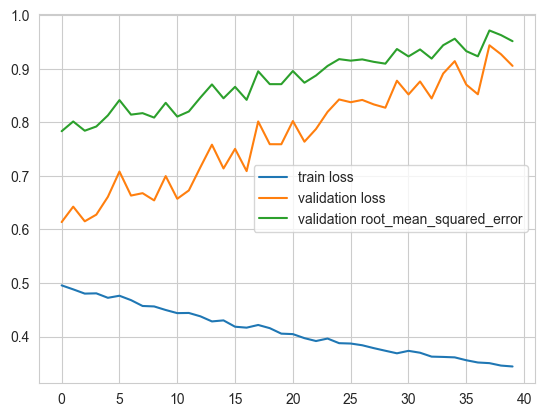

In [450]:
history = model_multi_s3.fit(x=[T, X], y=y, batch_size=BATCH_SIZE, validation_split=1/8, epochs=40)
show_results(X_t, T_t, y_t, model_multi_s3, history)